### Feature Engineering & Normalization

In [124]:
import pandas as pd
import numpy as np



importing and using the cleaned csv file 

In [141]:
df=pd.read_csv("cleaned_listings.csv")
df.head()


,price,room_type,neighbourhood,minimum_nights,availability_365
0,60,3,34,2,353
1,105,1,65,2,155
2,60,1,76,2,321
3,65,1,39,4,300
4,21,3,34,1,168


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6297 entries, 0 to 6296
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             6297 non-null   int64
 1   room_type         6297 non-null   int64
 2   neighbourhood     6297 non-null   int64
 3   minimum_nights    6297 non-null   int64
 4   availability_365  6297 non-null   int64
dtypes: int64(5)
memory usage: 246.1 KB


Creating new features


Low price but still high availability might indicate multiple factors like quality , competetiveness.

In [143]:
df['price_per_available_day'] = df['price'] / (df['availability_365'] + 1)  

Using standard scaler to maintain the range between features 

In [ ]:
# from sklearn.discriminant_analysis import StandardScaler

# scaler = StandardScaler()
# df[['price_per_available_day', 'minimum_nights', 'availability_365']] = scaler.fit_transform(df[['price_per_available_day', 'minimum_nights', 'availability_365']])
# df.head()

,price,room_type,neighbourhood,minimum_nights,availability_365,price_per_available_day
0,0.0060,3,34,-0.269711,1.286408,-0.349822
1,0.0105,1,65,-0.269711,-0.138761,-0.343043
2,0.0060,1,76,-0.269711,1.056078,-0.349595
3,0.0065,1,39,-0.180684,0.904924,-0.349197
4,0.0021,3,34,-0.314224,-0.045190,-0.350431


Since the price is in negative we are using the min-max scaler

In [144]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['price', 'minimum_nights', 'availability_365']] = scaler.fit_transform(df[['price', 'minimum_nights', 'availability_365']])
df.head()


,price,room_type,neighbourhood,minimum_nights,availability_365,price_per_available_day
0,0.0060,3,34,0.002004,0.967123,0.169492
1,0.0105,1,65,0.002004,0.424658,0.673077
2,0.0060,1,76,0.002004,0.879452,0.186335
3,0.0065,1,39,0.006012,0.821918,0.215947
4,0.0021,3,34,0.000000,0.460274,0.124260


Importing the final prep data into database

In [145]:
from sqlalchemy import create_engine

host = r'127.0.0.1' 
db = r'MSDS610' 
user = r'postgres' 
pw = r'smooth' 
port = r'5432'
schema = r'raw'

db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

table_name = r'final_prep_data'
schema = r'raw' 

df.to_sql(table_name, db_conn, if_exists='replace', index=False,schema='raw')

297

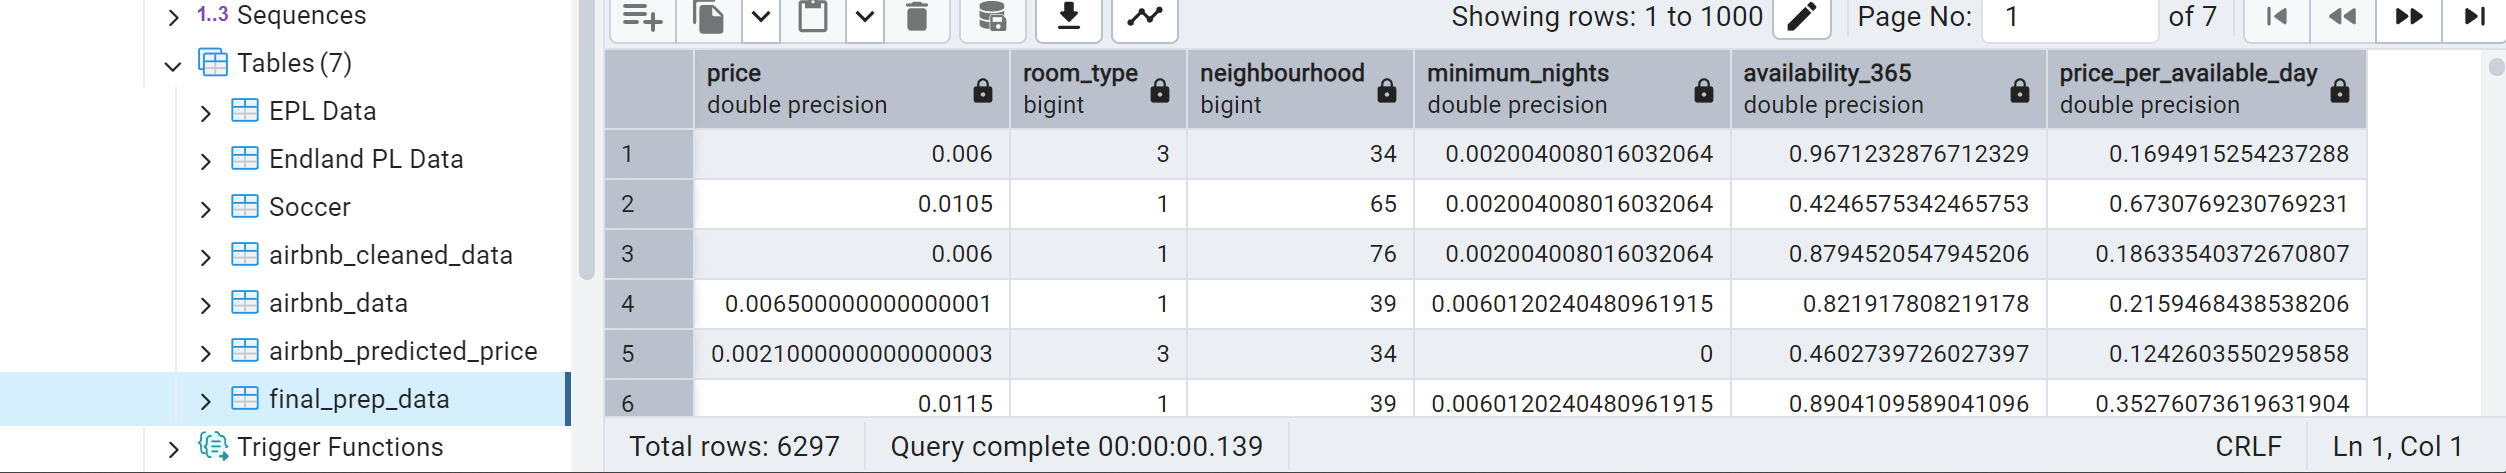

Performing 3-way split (70,15,15)

In [ ]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=['price'])  
y = df['price']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



Evaluating multiple models at once using for loop 

In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Defining models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
}

# Dictionaries to store the results
train_results = {}
val_results = {}
test_results = {}

for name, model in models.items():
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    train_results[name] = {"MAE": train_mae, "RMSE": train_rmse, "R2 Score": train_r2}
    
    y_val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
   
    val_results[name] = {"MAE": val_mae, "RMSE": val_rmse, "R2 Score": val_r2}
    
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    

    test_results[name] = {"MAE": test_mae, "RMSE": test_rmse, "R2 Score": test_r2}


train_results_df = pd.DataFrame(train_results).T
val_results_df = pd.DataFrame(val_results).T
test_results_df = pd.DataFrame(test_results).T


print("Training Set Evaluation:")
print(train_results_df)

print("\nValidation Set Evaluation:")
print(val_results_df)

print("\nTest Set Evaluation:")
print(test_results_df)


Training Set Evaluation:
                         MAE        RMSE  R2 Score
Linear Regression  96.824329  386.285451  0.033524
Decision Tree       0.000000    0.000000  1.000000
Random Forest       3.504021   43.721303  0.987619
Gradient Boosting  10.194991   22.189948  0.996811

Validation Set Evaluation:
                         MAE        RMSE  R2 Score
Linear Regression  85.515176  314.072905  0.049444
Decision Tree       8.282540   73.638665  0.947745
Random Forest       5.165228   38.335286  0.985838
Gradient Boosting  11.702753   31.644063  0.990351

Test Set Evaluation:
                         MAE        RMSE  R2 Score
Linear Regression  88.595195  358.947463  0.029078
Decision Tree      15.930159  287.977160  0.375060
Random Forest      13.257450  277.723964  0.418768
Gradient Boosting  20.140997  248.499809  0.534655


Choosing the best model based on validation set

In [133]:
import joblib

best_model_name = val_results_df['R2 Score'].idxmax() 
best_model = models[best_model_name]


print(f"\nBest Model based on Validation Set: {best_model_name}")

best_model.fit(X_train, y_train)

model_filename = f"{best_model_name.replace(' ', '_')}best_airbnb_model.pkl"
joblib.dump(best_model, model_filename)




Best Model based on Validation Set: Gradient Boosting


['Gradient_Boostingbest_airbnb_model.pkl']

Creating a .pkl file for the best model

In [134]:
import joblib
joblib.dump(best_model, "best_airbnb_model.pkl")


['best_airbnb_model.pkl']